## Model and key findings

The main approach used here to analyse topics in book reviews is Latent Dirichlet Allocation (LDA). LDA is a generative probabilistic model that allows one to estimate probability distributions for topics in documents and words. I chose this model because it overcomes limitations of previous methods such as TF-IDF, LSI and probabilistic LSI and is capable of capturing significant intra-document statistical structure.<br><br> Following text pre-processing (using stopwords, tokenisation, lemmatisation), I built 10 different LDA models with differing configurations: varying numbers of topics, passes, excluding short reviews, and different numbers of n-grams (uni-, bi- and trigrams).  In this notebook, I only show the best model (LDA model #5); for more information about the other models refer to the extra_info directory. I assessed model performance by visually inspecting the topics generated (whether they were sensible, and the degree of overlap), and by comparing perplexity and c_v coherence scores. Perplexity here is used as a figure of merit for comparing models, with lower perplexity scores indicating better generalisation performance. Topic coherence is essentially a measure of the quality of the learned topics. <br><br>
    The key findings of this modelling exercise using the best performing model (LDA model #5) are that themes common to some book genres (magic, love, storylines & plots) do come across as topics in the topic model, indicating that it may be worth developing distinct marketing strategies for  fantasy, romance, thriller books in particular. Another finding is that target audiences also come up as topics, in particular children and young adult, indicating that books for this demographic-range should be promoted in a way that targets this specific audience. An important potential limitation to bear in mind when interpreting these findings is that topics were manually labelled, and that there may be some bias imparted by the person labelling them.

### Imports and Settings

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk import FreqDist
from nltk.corpus import stopwords
import spacy

import gensim
from gensim import corpora
from gensim.models import CoherenceModel
import pyLDAvis   
import pyLDAvis.gensim

In [2]:
nltk.download('stopwords')
plt.style.use('ggplot')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
pd.set_option('display.max_columns', 20)

In [7]:
nlp = spacy.load('en', disable=['parser', 'ner'])
stop_words = stopwords.words('english')

### Configs

In [ ]:
FINAL_CLEAN_DATASET_PATH = '/Users/ddefforey1/work/capstone_datasets/final_clean_data.csv'

### Text Preprocessing

#### Unigrams

In [4]:
book_reviews = pd.read_csv(FINAL_CLEAN_DATASET_PATH, dtype=object)

In [6]:
# renaming the isbn column
book_reviews = book_reviews.rename(columns={'reviews': 'reviews', 'n_helpful': 'n_helpful', 'time': 'time', 'user': 'user', 'id': 'id', 
                             'book_title': 'book_title', 'author': 'author', 'isbn_x': 'isbn', 'book_genres': 'book_genres', 
                             'language': 'language'})

In [8]:
# here I'm adding more stopwords to better differentiate topics 
# I'm assuming that these words aren't important for my topic models
more_stopwords = ['http', 'www', 'com', 'html', 'amp', 'book', 'bit', 'little', 'lot', 'thing', 'something', 'way', 
                  'many', 'much', 'page', 'reader', 'first']
stop_words.extend(more_stopwords)

In [9]:
def remove_stopwords(rev):
    rev_new = " ".join([i for i in rev if i not in stop_words])
    return rev_new

In [10]:
def lemmatize_text(texts, tags=['NOUN', 'ADJ']):
    output = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        output.append([token.lemma_ for token in doc if token.pos_ in tags])
    return output

In [11]:
# replace "n't" with " not", remove unwanted characters, numbers and symbols
book_reviews['processed_reviews'] = book_reviews['reviews'].str.replace("n\'t", " not").str.replace("[^a-zA-Z#]", " ")

In [12]:
# remove short words (length < 3)
book_reviews['processed_reviews'] = book_reviews['processed_reviews'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>2]))

# remove stopwords from the text
reviews = [remove_stopwords(r.split()) for r in book_reviews['processed_reviews']]

# make entire text lowercase
reviews = [r.lower() for r in reviews]

In [13]:
tokenized_reviews = pd.Series(reviews).apply(lambda x: x.split())

In [14]:
lemma_reviews = lemmatize_text(tokenized_reviews)

In [15]:
clean_reviews = []
for i in range(len(lemma_reviews)):
    clean_reviews.append(' '.join(lemma_reviews[i]))
    
book_reviews['processed_reviews'] = clean_reviews

In [16]:
book_reviews['tokenized_reviews'] = tokenized_reviews
book_reviews['lemmatized_reviews'] = lemma_reviews

In [19]:
# determine the length of processed reviews
book_reviews['word_counts'] = book_reviews['processed_reviews'].str.count(' ') + 1

#### Bigrams

In [20]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(tokenized_reviews, min_count=5, threshold=100) # higher threshold fewer phrases

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)

In [24]:
def make_bigrams(reviews):
    return [bigram_mod[word] for word in reviews]

In [25]:
review_bigrams = make_bigrams(tokenized_reviews)
lemma_reviews_bigrams = lemmatize_text(review_bigrams)

### LDA Model

I trained and tuned 10 different LDA models to optimise c_v coherence score, perplexity and most importantly human interpretability. Ultimately, I prioritised the latter and found that my fifth model (bigrams, 20 topics, 10 passes, no length restriction on reviews) produced the most interpretable and useful results given the problem I am working on.

#### LDA model #5: bigrams, 20 topics, 10 passes, no length restriction on reviews 

In [76]:
# Create the term dictionary of our corpus, where every unique term is assigned an index
bigram_dictionary = corpora.Dictionary(lemma_reviews_bigrams)

In [77]:
bigram_doc_term_matrix = [bigram_dictionary.doc2bow(rev) for rev in lemma_reviews_bigrams]

In [78]:
# model using bigrams, 20 topics and 10 corpus passes
lda_model5 = LDA(corpus=bigram_doc_term_matrix,
                id2word=bigram_dictionary,
                num_topics=20, 
                random_state=1,
                passes=10
               )

In [79]:
lda_model5.print_topics()

[(0,
  '0.068*"world" + 0.048*"fantasy" + 0.028*"magic" + 0.026*"dark" + 0.019*"evil" + 0.018*"power" + 0.017*"tale" + 0.017*"adventure" + 0.015*"magical" + 0.014*"witch"'),
 (1,
  '0.100*"child" + 0.062*"story" + 0.037*"picture" + 0.032*"great" + 0.028*"animal" + 0.025*"illustration" + 0.021*"different" + 0.020*"student" + 0.017*"word" + 0.014*"young"'),
 (2,
  '0.157*"woman" + 0.092*"man" + 0.044*"husband" + 0.031*"chinese" + 0.029*"wife" + 0.026*"american" + 0.023*"young" + 0.022*"white" + 0.017*"america" + 0.016*"marriage"'),
 (3,
  '0.118*"funny" + 0.069*"fun" + 0.061*"humor" + 0.042*"island" + 0.026*"delightful" + 0.024*"humorous" + 0.022*"charming" + 0.022*"light" + 0.022*"bear" + 0.021*"witty"'),
 (4,
  '0.041*"war" + 0.021*"man" + 0.019*"city" + 0.016*"death" + 0.016*"world" + 0.014*"history" + 0.011*"london" + 0.011*"england" + 0.009*"country" + 0.007*"century"'),
 (5,
  '0.058*"character" + 0.051*"mystery" + 0.048*"story" + 0.034*"plot" + 0.024*"murder" + 0.020*"interesting"

In [80]:
print('\nPerplexity: ', lda_model5.log_perplexity(bigram_doc_term_matrix))  

coherence_model_lda5 = CoherenceModel(model=lda_model5, texts=lemma_reviews_bigrams, dictionary=bigram_dictionary, coherence='c_v')
coherence_lda5 = coherence_model_lda5.get_coherence()
print('\nCoherence Score: ', coherence_lda5)


Perplexity:  -12.460024258119146

Coherence Score:  0.41390898966638723


In [81]:
#lda_model5.save('lda_model_5')

In [82]:
pyLDAvis.enable_notebook()
lda_model_vis5 = pyLDAvis.gensim.prepare(lda_model5, bigram_doc_term_matrix, bigram_dictionary, sort_topics=False)
pyLDAvis.save_html(lda_model_vis5, 'lda_model5.html')

The key characteristic of this model is that it uses bigrams. While the coherence score did not change much, the use of bigrams did slightly lower perplexity. It also resulted in less overlap between topics, which is preferable. Compared to other models, this one provides the best compromise of all performance metrics and I therefore chose to use it in my analysis.

#### [Link to interactive LDA topic visualisation for model #5](./resources/lda_model5.html)

<b>Interpretation and annotation of the topics generated by model 5 (note that the LDA model is numbered from 0 to 19, I will follow the numbering scheme from pyLDAvis, ie 1 to 20:</b><br>
    1. Magic/supernatural<br>
    2. Children's books<br>
    3. Non-fiction, with some family elements<br>
    4. Mix of emotions, both positive (e.g. humorous) and negative (e.g. sadness)<br>
    5. War<br>
    6. Plot and story<br>
    7. Mix of things, difficult to label<br>
    8. Reader experience<br>
    9. Non/fiction, with some literature elements<br>
    10. Book series, saga<br>
    11. Adventure<br>
    12. Storytelling<br>
    13. Work, career/professional life<br>
    14. Family<br>
    15. Love and courtship<br>
    16. Mix of things, mostly fiction and horror<br>
    17. Children/young adult<br>
    18. Character interactions, including erotica<br>
    19. Philosophy, high-minded ideas (society, culture, religion, science)<br>
    20. Mix of things, difficult to label

Because the annotation above requires some human interpretation, it may be impacted by some bias so care should be taken when using these findings.

### Topic Predictions

#### Using a trained LDA model (model #5) to predict topics from book reviews

In [110]:
# loading model 5, which gave the best results
lda_model5 = gensim.models.ldamodel.LdaModel.load('lda_model_5')

In [111]:
def predict_topics(doc_term_matrix, book_reviews, lda_model):
    """
    Uses a trained LDA model to predict topics from book reviews. Returns a dataframe with the relative fraction each topic represents in each review.
    """
    topic_preds = []
    for entry in doc_term_matrix:
        model_output = lda_model.get_document_topics(entry)
        output_dict = dict(model_output)
        topic_preds.append(output_dict)
    df = pd.DataFrame(topic_preds)
    df['book_genre'] = book_reviews.book_genres.copy()
    return df

In [112]:
topic_predictions = predict_topics(bigram_doc_term_matrix, book_reviews, lda_model5)

In [113]:
# adding a column to the dataframe with book genre info for each review
topic_predictions['book_genre'] = book_reviews.book_genres.copy()

In [114]:
# verifying the topic predictions dataframe is as expected
topic_predictions.head()

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,book_genre
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.549775,NaN,0.321652,NaN,fantasy
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.312393,0.035878,0.081952,...,0.301012,NaN,NaN,NaN,NaN,0.139823,NaN,NaN,NaN,fantasy
2,0.099908,NaN,0.069876,0.070034,NaN,NaN,NaN,0.120377,0.070077,NaN,...,0.330703,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.078375,fantasy
3,0.065718,NaN,NaN,NaN,NaN,0.162595,NaN,0.112833,0.065720,0.267611,...,NaN,NaN,NaN,0.066513,NaN,0.093507,NaN,NaN,NaN,fantasy
4,NaN,NaN,NaN,NaN,NaN,0.134261,NaN,NaN,0.164462,NaN,...,NaN,NaN,NaN,0.058353,NaN,NaN,NaN,NaN,0.406912,fantasy


In [115]:
# replacing NaNs with 0 for topics that are not present in book reviews
topic_predictions.fillna(0, inplace=True)

In [116]:
# renaming the columns so the numbering scheme matches that of pyLDAvis
topic_predictions.rename(columns={0: 'topic_1', 1: 'topic_2', 2: 'topic_3', 3: 'topic_4', 4: 'topic_5',
                                 5: 'topic_6', 6: 'topic_7', 7: 'topic_8', 8: 'topic_9', 9: 'topic_10', 10: 'topic_11',
                                 11: 'topic_12', 12: 'topic_13', 13: 'topic_14', 14: 'topic_15', 15: 'topic_16',
                                 16: 'topic_17', 17: 'topic_18', 18: 'topic_19', 19: 'topic_20'}, inplace=True)

In [117]:
# adding a numbering scheme for each review
topic_predictions['review_number'] = pd.Series(range(1,272600,1))
topic_predictions['review_number'] = topic_predictions['review_number'].astype(int)

In [118]:
topic_predictions.head()

,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,...,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,book_genre,review_number
0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.000000,0.0,0.549775,0.0,0.321652,0.000000,fantasy,1
1,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.312393,0.035878,0.081952,...,0.0,0.0,0.000000,0.0,0.139823,0.0,0.000000,0.000000,fantasy,2
2,0.099908,0.0,0.069876,0.070034,0.0,0.000000,0.0,0.120377,0.070077,0.000000,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.078375,fantasy,3
3,0.065718,0.0,0.000000,0.000000,0.0,0.162595,0.0,0.112833,0.065720,0.267611,...,0.0,0.0,0.066513,0.0,0.093507,0.0,0.000000,0.000000,fantasy,4
4,0.000000,0.0,0.000000,0.000000,0.0,0.134261,0.0,0.000000,0.164462,0.000000,...,0.0,0.0,0.058353,0.0,0.000000,0.0,0.000000,0.406912,fantasy,5


#### Interpretation of model predictions

After having generated a dataframe of topic predictions using model 5, I now use bar plots to visualise topic weights for each topic and how these change across seven book genres (fantasy, science-fiction, mystery, thriller, romance, fiction and non-fiction). The first couple of plots provide a general overview of these topic weights, and the later ones hone in on subsets of genres and topics to glean. Comments interpreting these plots are provided below these figures.

In [119]:
melted_topics = pd.melt(topic_predictions, id_vars=['review_number', 'book_genre'], value_vars=['topic_1', 'topic_2', 'topic_3', 'topic_4', 'topic_5', 'topic_6', 'topic_7',
                                                     'topic_8', 'topic_9', 'topic_10', 'topic_11', 'topic_12', 'topic_13', 'topic_14', 
                                                     'topic_15', 'topic_16', 'topic_17', 'topic_18', 'topic_19', 'topic_20'])

In [120]:
melted_topics.head()

,review_number,book_genre,variable,value
0,1,fantasy,topic_1,0.000000
1,2,fantasy,topic_1,0.000000
2,3,fantasy,topic_1,0.099908
3,4,fantasy,topic_1,0.065718
4,5,fantasy,topic_1,0.000000


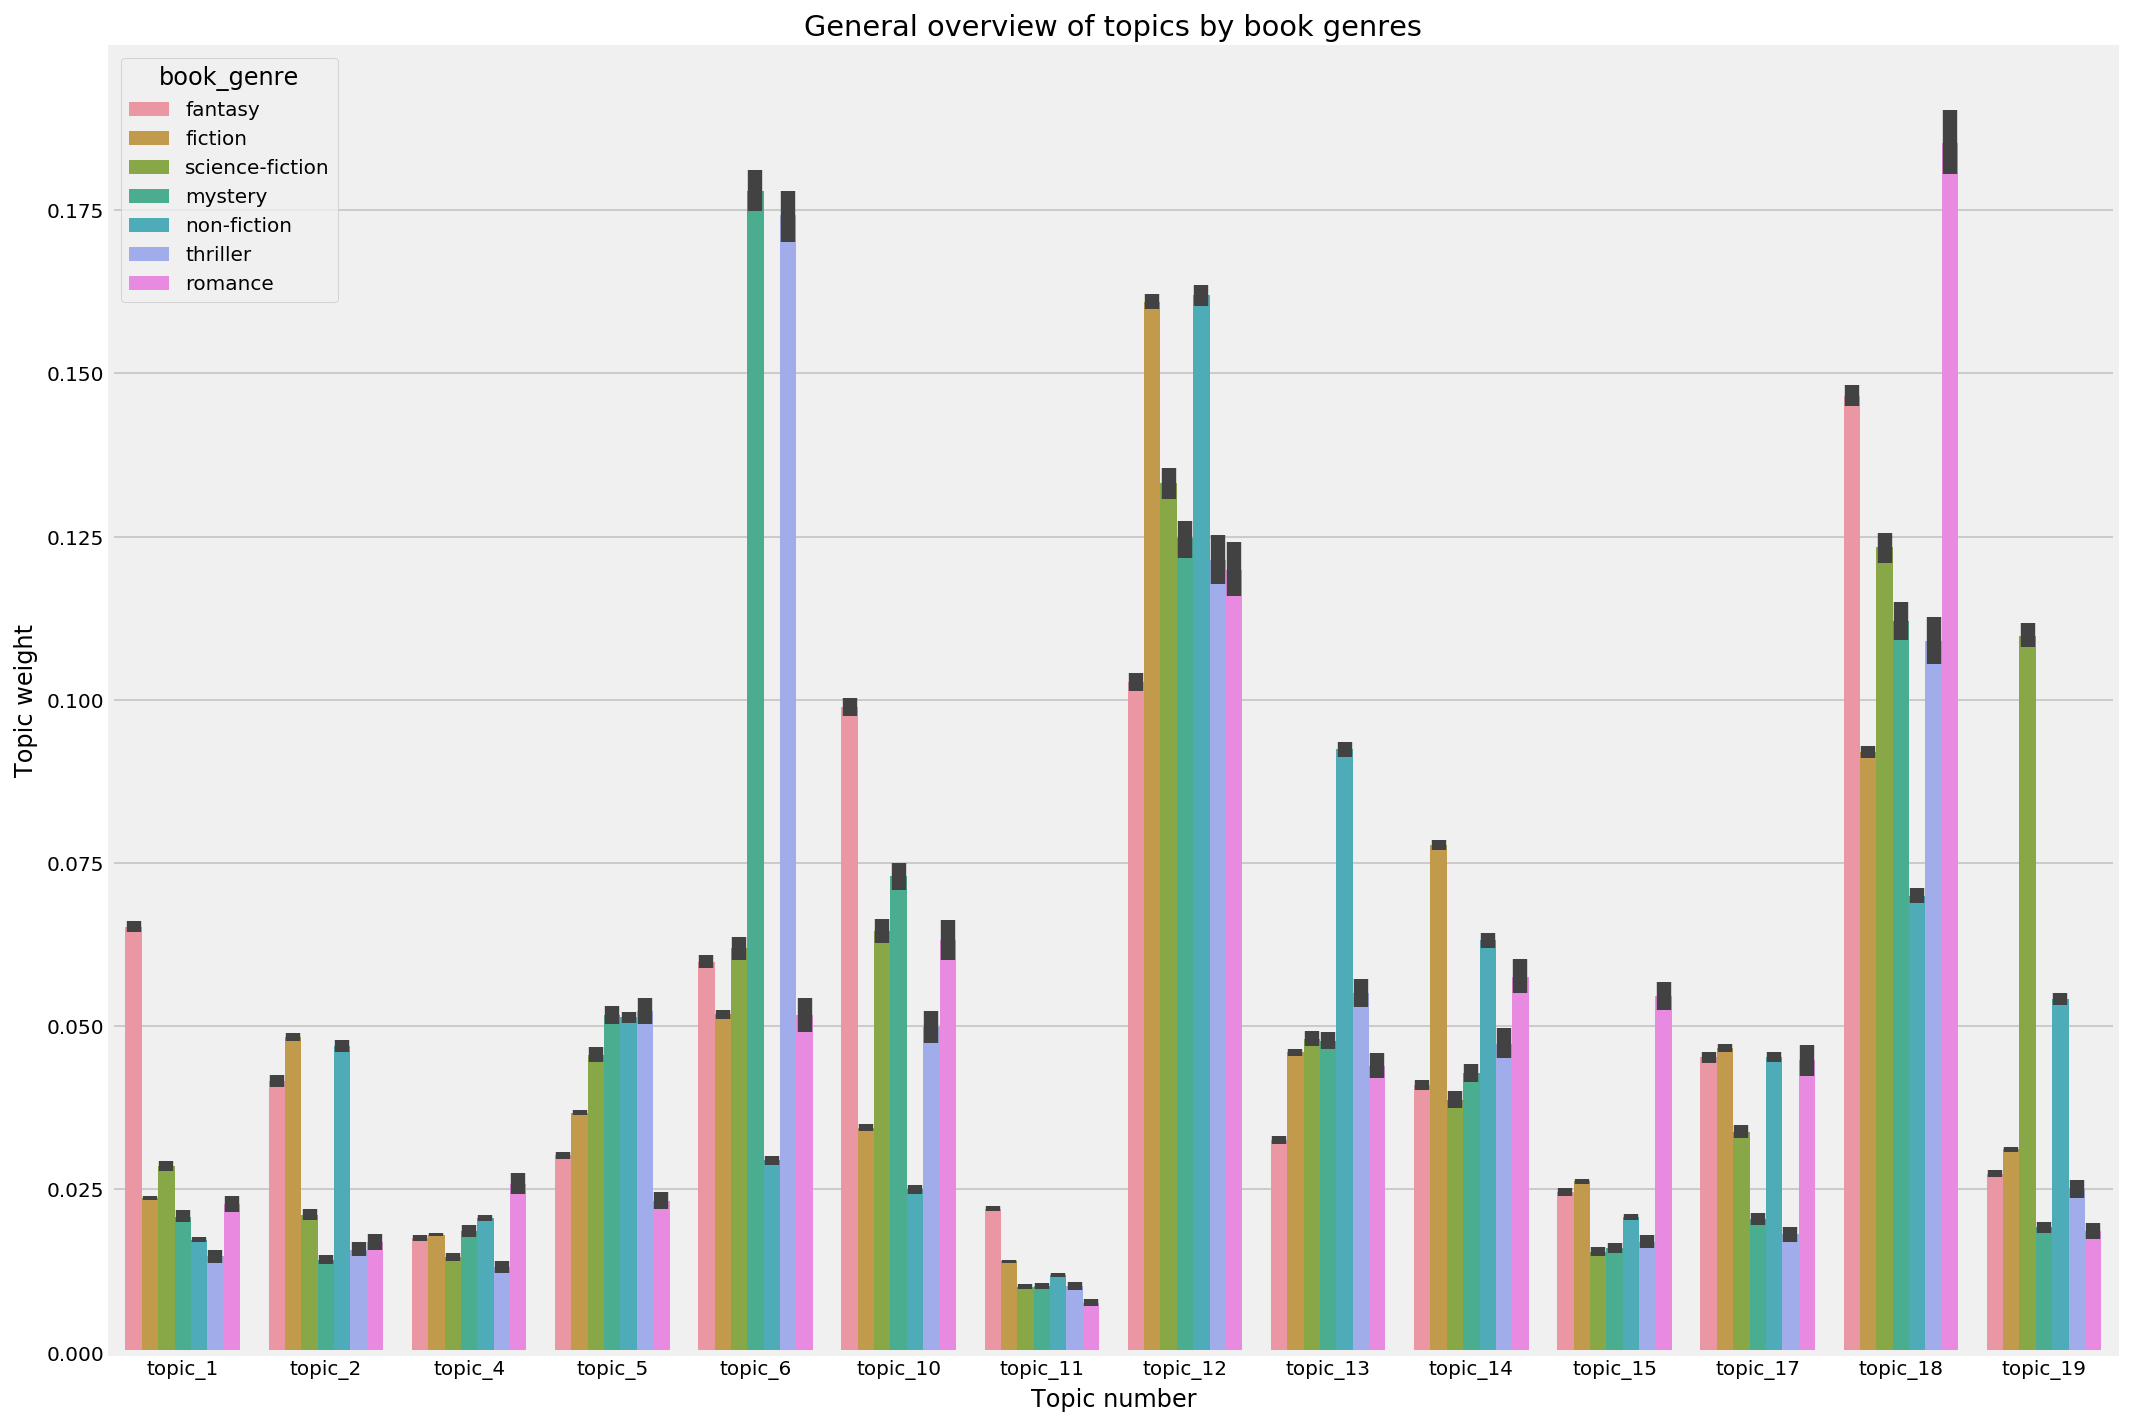

In [121]:
EXCLUDED_TOPICS = ['topic_3', 'topic_7', 'topic_8', 'topic_9', 'topic_16', 'topic_20']

fig = plt.figure(figsize=(16, 12))
ax = fig.gca()    
sns.barplot(
    x='variable',
    y="value",
    hue="book_genre",
    data=melted_topics[
        ~ melted_topics.variable.isin(EXCLUDED_TOPICS)
    ],
    ax=ax,
)
ax.set_ylabel('Topic weight')
ax.set_xlabel('Topic number')
_ = ax.set_title('General overview of topics by book genres')

At a glance, there is quite a bit of variation in terms of topic weights for different genres. This is particularly the case for topics 6 (plot line, story), 12 (storytelling), 18 (character interactions) and 19 (philosophy, high-minded ideas). This suggests that focusing on topics with the highest weight when developing promotion materials for a given book genre would be an effective course of action, since these themes are prevalent in consumer reviews.

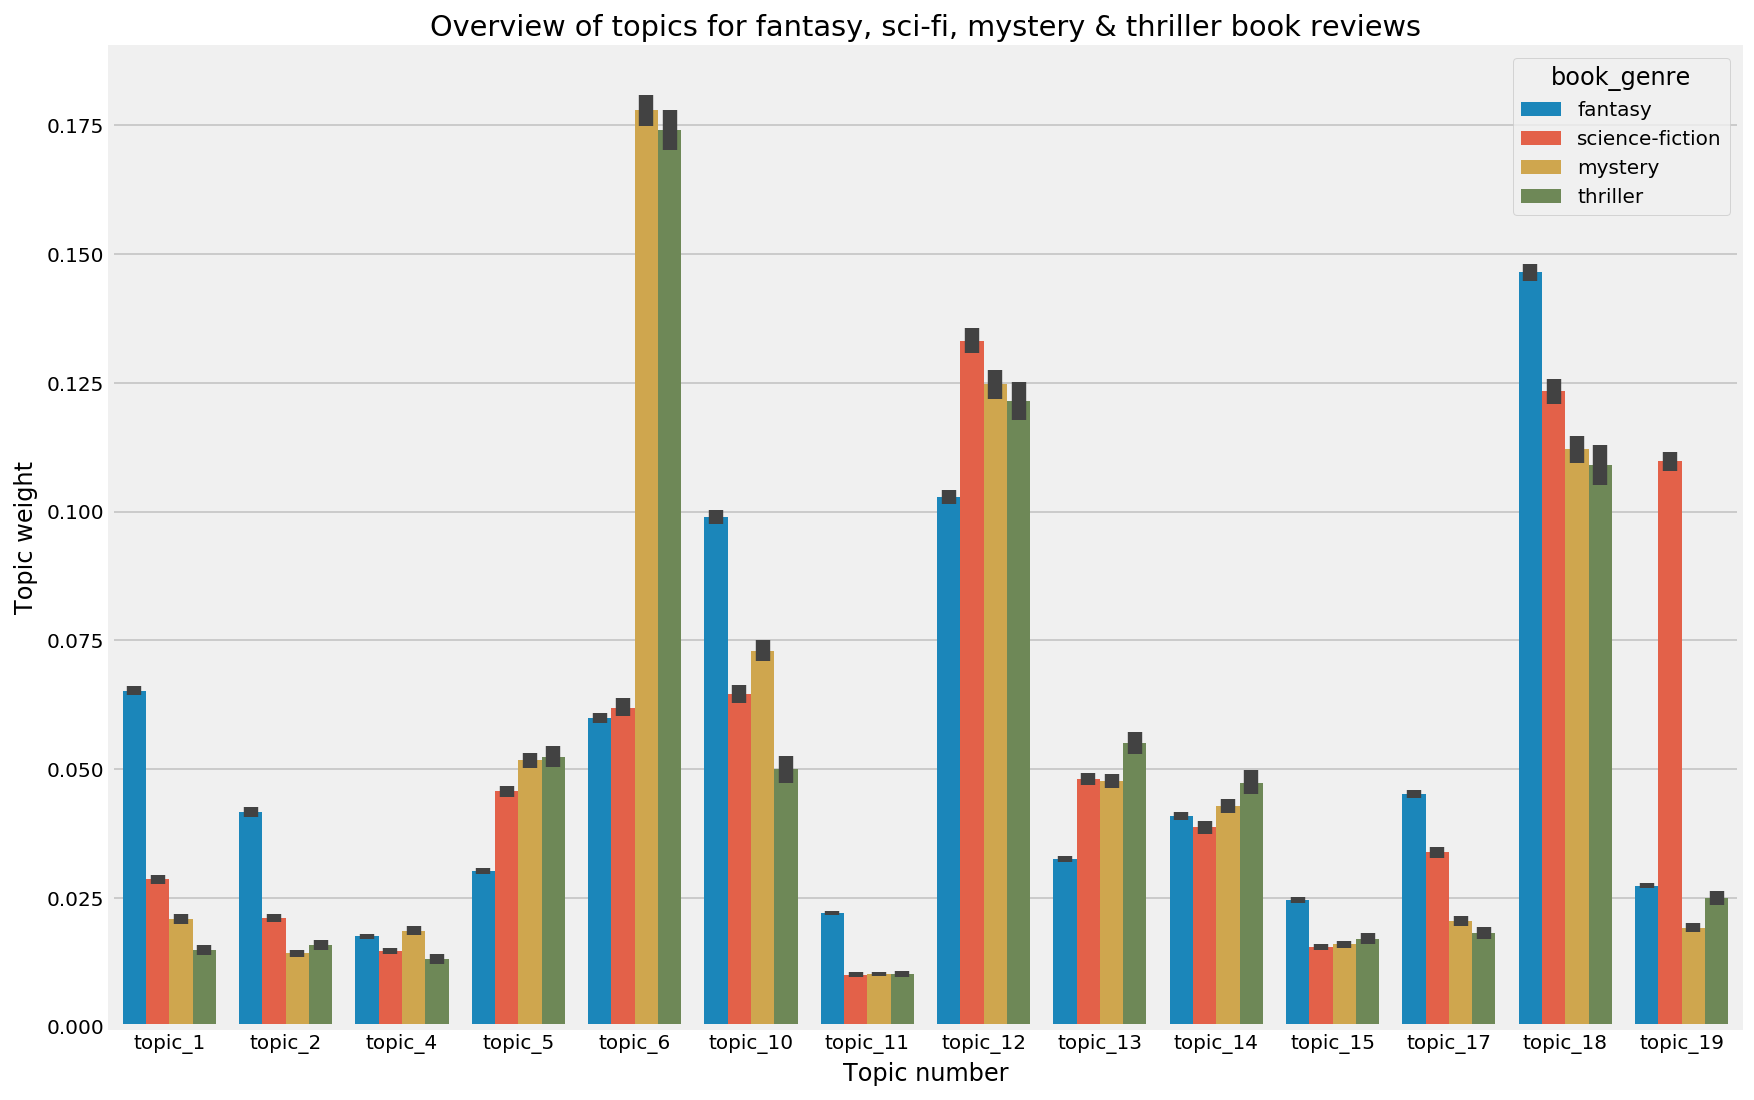

In [122]:
EXCLUDED_TOPICS = ['topic_3', 'topic_7', 'topic_8', 'topic_9', 'topic_16', 'topic_20']
INCLUDED_GENRES = ['fantasy', 'science-fiction', 'mystery', 'thriller']

fig = plt.figure(figsize=(13, 9))
ax = fig.gca()    
sns.barplot(
    x='variable',
    y="value",
    hue="book_genre",
    data=melted_topics[
        ~ melted_topics.variable.isin(EXCLUDED_TOPICS)
        & melted_topics.book_genre.isin(INCLUDED_GENRES)
    ],
    ax=ax,
)
ax.set_ylabel('Topic weight')
ax.set_xlabel('Topic number')
_ = ax.set_title('Overview of topics for fantasy, sci-fi, mystery & thriller book reviews')

This bar plot, which focuses only on 4 fiction genres, shows that while there are common topics fiction readers care about, some clear genre-specific trends also emerge. Mystery and thriller readers care most about a book's plot line and story (topic 6). Fantasy readers care most about character interactions (topic 18), storytelling (topic 12), magic/the supernatural (topic 1) but also, interestingly, about sagas and book series (topic 10). The latter suggests that emphasising the place a book holds in a saga when promoting it can improve its visibility (e.g. "Oathbringer, book 3 of the Stormlight Archive series" instead of "Brandon Sanderson's epic fantasy novel Oathbringer"). Lastly, while science-fiction readers also care about storytelling and character interactions, it is interesting to see that topics such as philisophy/high-minded ideas (topic 19) are also prevalent and those could be incorporated in book advertisements.

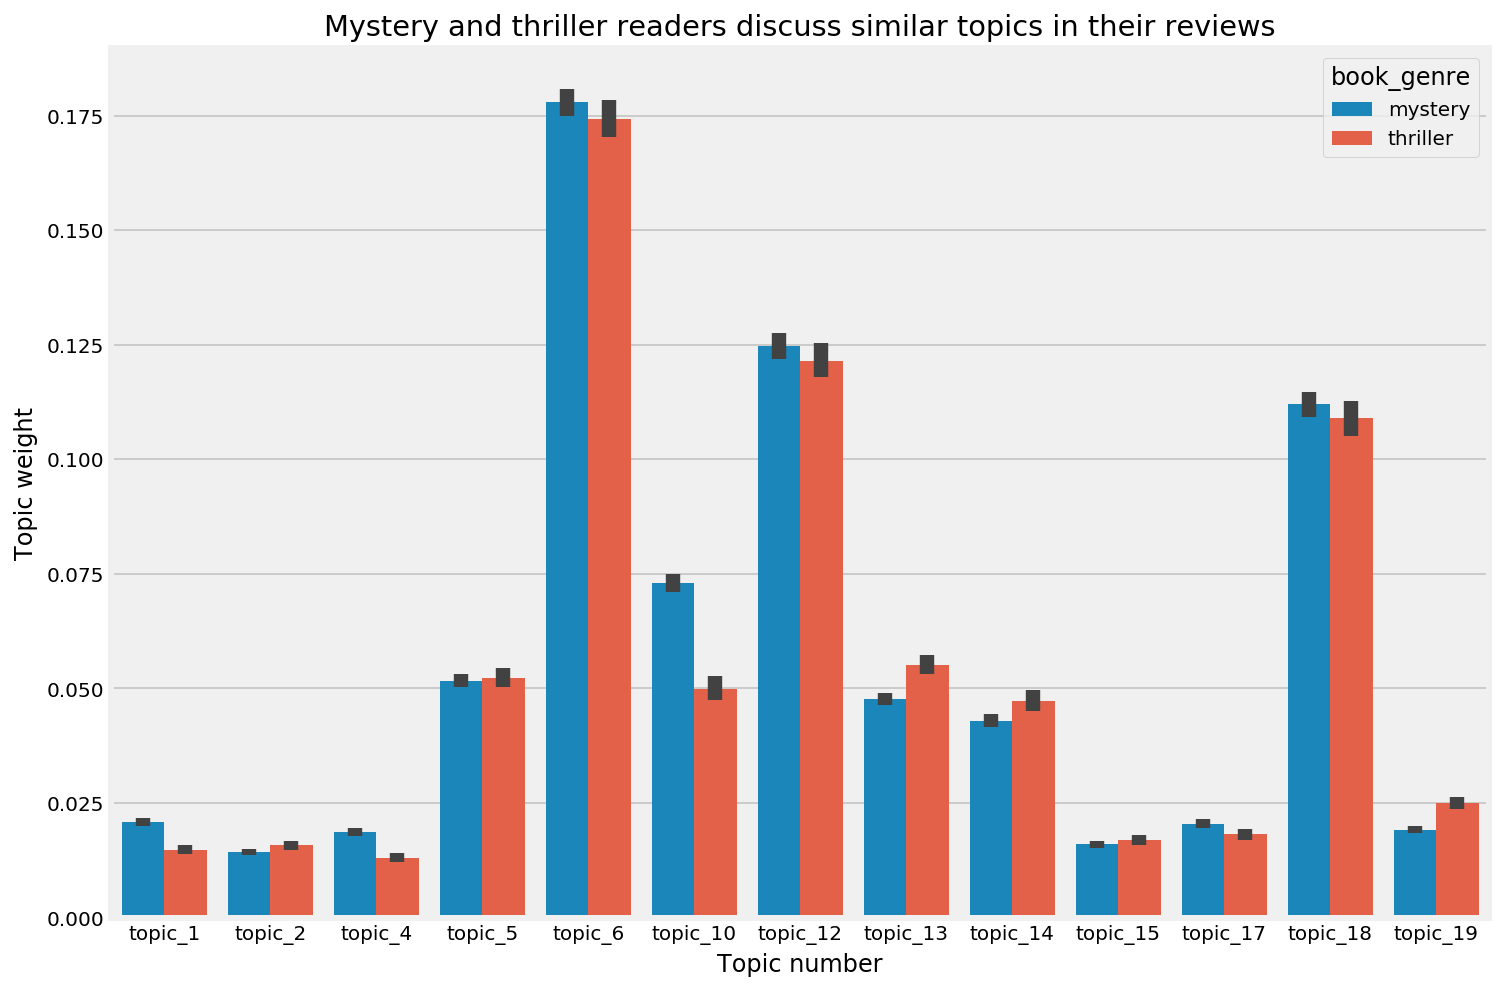

In [123]:
EXCLUDED_TOPICS = ['topic_3', 'topic_7', 'topic_8', 'topic_9', 'topic_11', 'topic_16', 'topic_20']
INCLUDED_GENRES = ['mystery', 'thriller']

fig = plt.figure(figsize=(11, 8))
ax = fig.gca()    
_ = sns.barplot(
    x='variable',
    y="value",
    hue="book_genre",
    data=melted_topics[
        ~ melted_topics.variable.isin(EXCLUDED_TOPICS)
        & melted_topics.book_genre.isin(INCLUDED_GENRES)
    ],
    ax=ax,
)
ax.set_ylabel('Topic weight')
ax.set_xlabel('Topic number')
_ = ax.set_title('Mystery and thriller readers discuss similar topics in their reviews')

Mystery and thriller book reviews seem to have similar topics, so for simplicity I will remove the thriller genre. Readers of these genres mainly care about a book's plot line, and storytelling.

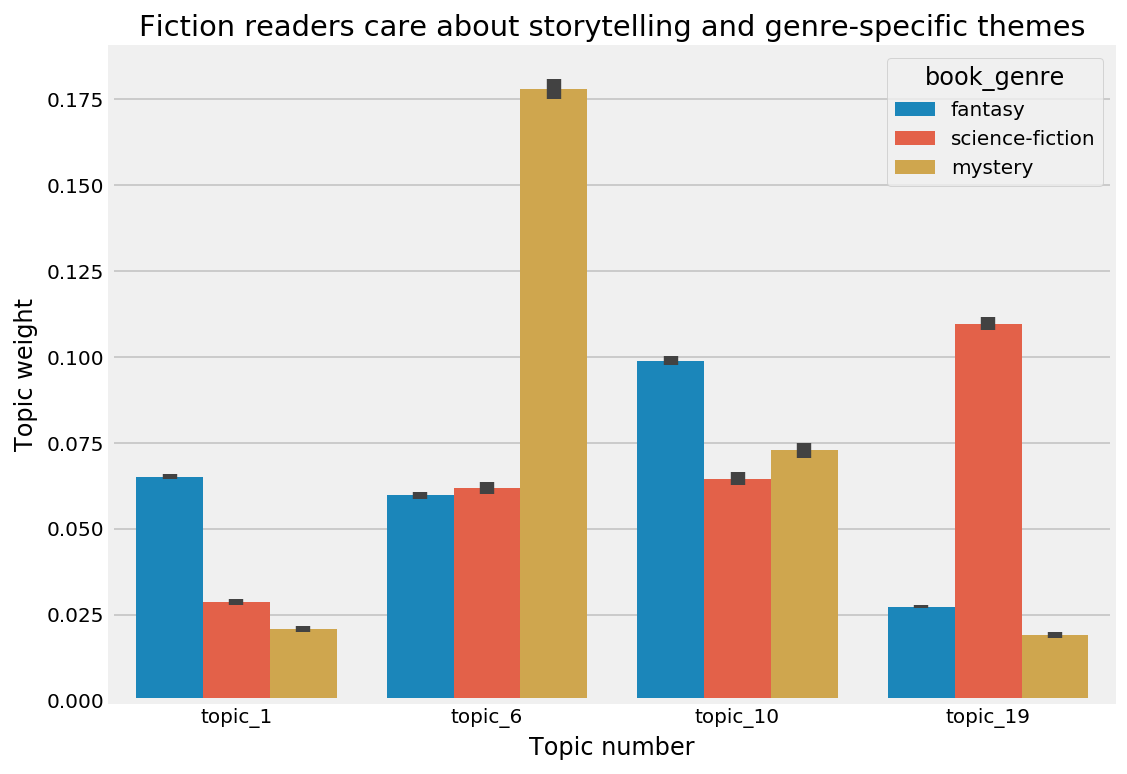

In [124]:
EXCLUDED_TOPICS = ['topic_2', 'topic_3', 'topic_4', 'topic_5', 'topic_7', 'topic_8', 'topic_9', 'topic_11', 'topic_12', 'topic_13', 'topic_14',
                   'topic_15', 'topic_16', 'topic_17', 'topic_18', 'topic_20']
INCLUDED_GENRES = ['fantasy', 'science-fiction', 'mystery']

fig = plt.figure(figsize=(8, 6))
ax = fig.gca()    
sns_plot1 = sns.barplot(
        x='variable',
        y="value",
        hue="book_genre",
        data=melted_topics[
            ~ melted_topics.variable.isin(EXCLUDED_TOPICS)
            & melted_topics.book_genre.isin(INCLUDED_GENRES)
        ],
        ax=ax,
    )
ax.set_ylabel('Topic weight')
ax.set_xlabel('Topic number')
_ = ax.set_title('Fiction readers care about storytelling and genre-specific themes')

Fantasy readers care most about themes like magic and the supernatural, and sagas/book series. Mystery readers on the other hand mainly care about a book's plot, and science-fiction readers about philosophy/high-minded ideas. Readers of all three genres care about character interactions and storytelling (topics 12 and 18, not shown in this figure for clarity).

In [125]:
fig.savefig("fiction_topics.eps")

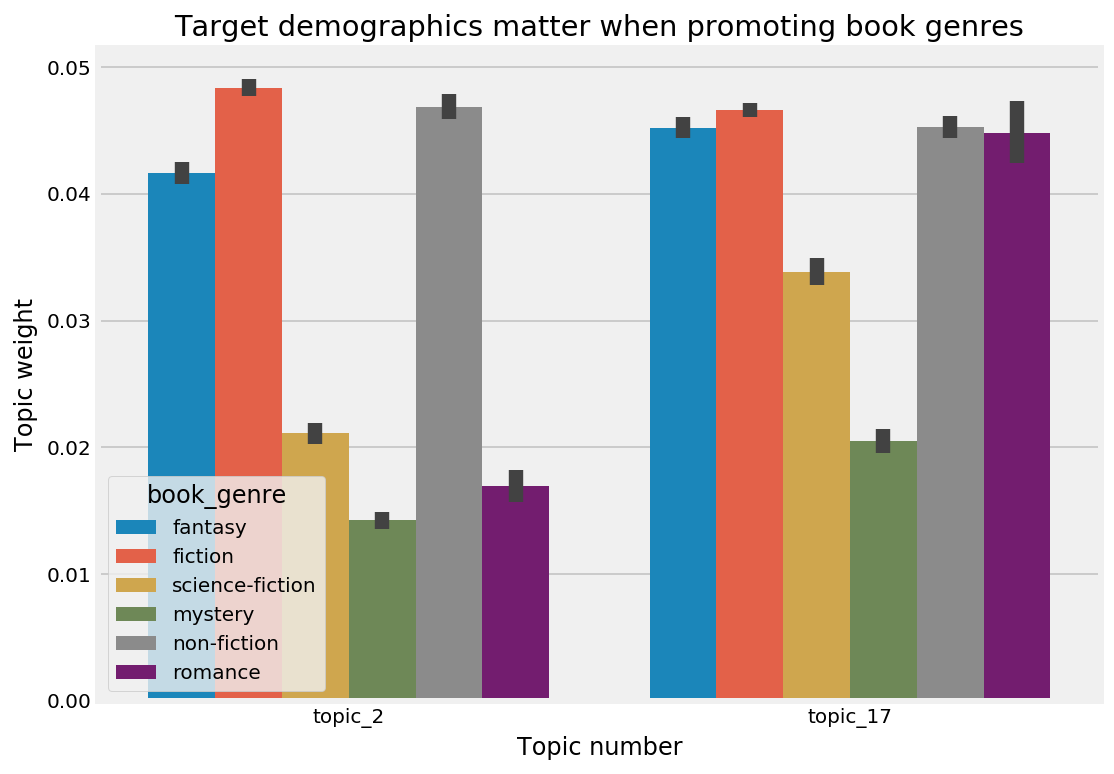

In [126]:
EXCLUDED_TOPICS = ['topic_1', 'topic_3', 'topic_4', 'topic_5', 'topic_6', 'topic_7', 'topic_8', 'topic_9', 'topic_10', 'topic_11',
                   'topic_12', 'topic_13', 'topic_14', 'topic_15', 'topic_16', 'topic_18', 'topic_19', 'topic_20']
INCLUDED_GENRES = ['fantasy', 'science-fiction', 'mystery', 'romance', 'fiction', 'non-fiction']

fig = plt.figure(figsize=(8, 6))
ax = fig.gca()    
sns.barplot(
    x='variable',
    y="value",
    hue="book_genre",
    data=melted_topics[
        ~ melted_topics.variable.isin(EXCLUDED_TOPICS)
        & melted_topics.book_genre.isin(INCLUDED_GENRES)
    ],
    ax=ax,
    )
ax.set_ylabel('Topic weight')
ax.set_xlabel('Topic number')
_ = ax.set_title('Target demographics matter when promoting book genres')

Children's books tend to be mostly fantasy, fiction or non-fiction (e.g. educational books), while young adults read those genres as well as more romance.

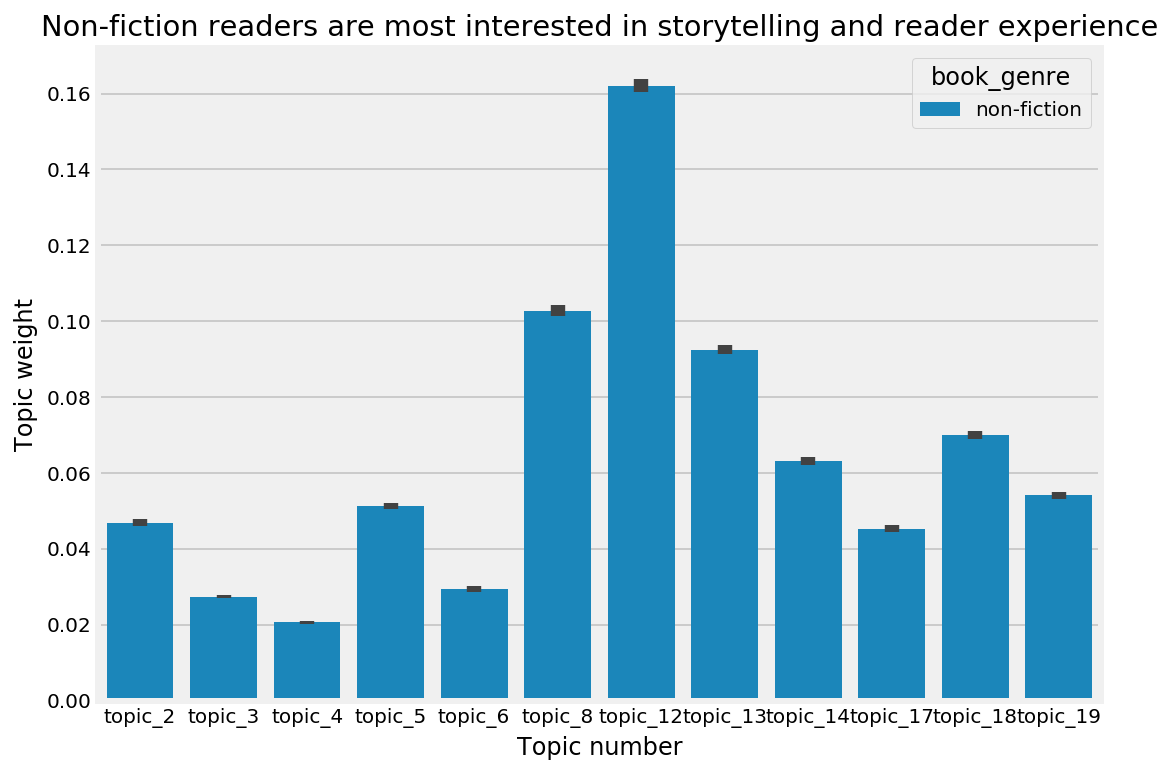

In [127]:
EXCLUDED_TOPICS = ['topic_1', 'topic_7', 'topic_9', 'topic_10','topic_11', 'topic_15', 'topic_16', 'topic_20']
INCLUDED_GENRES = ['non-fiction']

fig = plt.figure(figsize=(8, 6))
ax = fig.gca()    
sns.barplot(
    x='variable',
    y="value",
    hue="book_genre",
    data=melted_topics[
        ~ melted_topics.variable.isin(EXCLUDED_TOPICS)
        & melted_topics.book_genre.isin(INCLUDED_GENRES)
    ],
    ax=ax,
)
ax.set_ylabel('Topic weight')
ax.set_xlabel('Topic number')
_ = ax.set_title('Non-fiction readers are most interested in storytelling and reader experience')

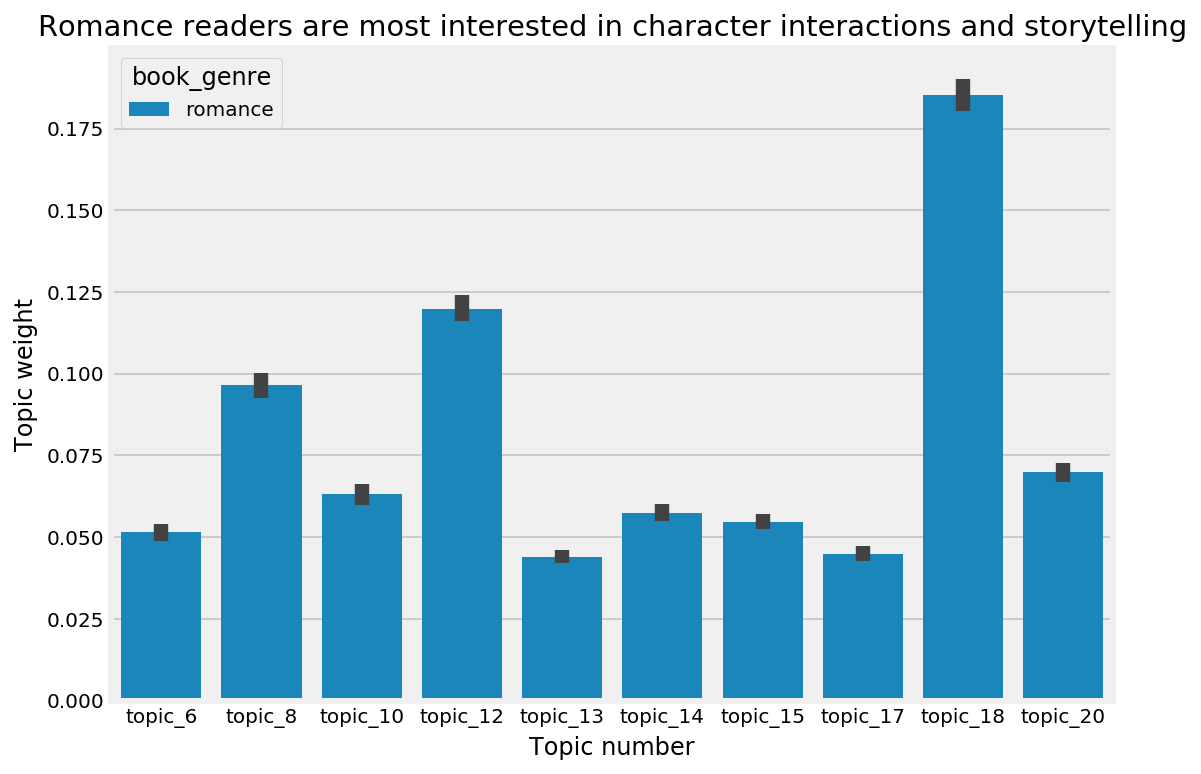

In [128]:
EXCLUDED_TOPICS = ['topic_1', 'topic_2', 'topic_3', 'topic_4', 'topic_5', 'topic_7', 'topic_9', 'topic_11', 'topic_16', 'topic_19']
INCLUDED_GENRES = ['romance']

fig = plt.figure(figsize=(8, 6))
ax = fig.gca()    
sns.barplot(
    x='variable',
    y="value",
    hue="book_genre",
    data=melted_topics[
        ~ melted_topics.variable.isin(EXCLUDED_TOPICS)
        & melted_topics.book_genre.isin(INCLUDED_GENRES)
    ],
    ax=ax,
)
ax.set_ylabel('Topic weight')
ax.set_xlabel('Topic number')
_ = ax.set_title('Romance readers are most interested in character interactions and storytelling')